#### RNN, LSTM, GRU regression of mouse wheel speed based on Steinmetz `spks` dataset and code from [nma](https://deeplearning.neuromatch.io/projects/Neuroscience/neuro_seq_to_seq.html)

__Note__: You must restart the notebook for training the LSTM and GRU models and each time you rerun a model. This appears to be an issue of the previous model remaining on the GPU after training.

##### Imports

In [1]:
# Imports
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, io, models, ops, transforms, utils
from matplotlib import pyplot as plt

##### Device

In [2]:
# @title Set device (GPU or CPU). Execute `set_device()`

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

##### Set random seed

In [3]:
# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [4]:
SEED = 2021
set_seed(seed=SEED)
device = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


##### Data retrieval

In [5]:
# store the dataset files in the datasets folder
import os, requests

fname = []
ds = "../datasets"

for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile("/".join([ds, fname[j]])):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open("/".join([ds, fname[j]]), "wb") as fid:
          fid.write(r.content)

In [6]:
# data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load("/".join([ds, 'steinmetz_part%d.npz'%j]),
                              allow_pickle=True)['dat']))

##### Select recording 13

In [7]:
# select recording 13
dat = alldat[13]

##### Format dataset
An RNN has specific data requirements fed into the network for training, testing, and prediction. The depth of the network in a time or data series is given by `hidden_size`. In the case of the `spks` dataset this is 250 because one trial lasts for this many samples. These are the 250 sequenced datapoints related to the same mouse event trial from the same probe sensor size of 698 neurons over a time period of 2500ms. Further mouse trials are added in sequence in the dataset, where the training and forward algorithms reset to the start of the RNN. This dataset is then 698 neurons wide with 250 datapoints and 340 trials in length, before being split into train and test sets.

In [8]:
def shuffle_dataset(X, y):
  """
  Helper function to shuffle and split data
  Assumes that set_seed has already been run

  Args:
    X: torch.tensor
      Input data trials X time samples X neurons
    y: torch.tensor
      Corresponding one hot target variables as trials x categories
      
  Returns:
    X: torch.tensor
    y: torch.tensor
  """

  # Number of trials
  N = X.shape[0]

  # Shuffle data
  shuffled_indices = np.random.permutation(N) 
  X = X[shuffled_indices, :, :]
  y = y[shuffled_indices, :]
  
  return X, y

In [9]:
# data are neurons X trials x time samples, but permute to trials X time samples X neurons
x = torch.tensor(dat['spks']).permute(1,2,0)
x = x[:,50:150,:]

# response is -1, 0, 1, but convert to one hot where 2 takes the place of -1 to satisfy torch one hot
dat['response'][dat['response'] == -1] = 2 
y = torch.as_tensor(dat['response']).long()
y = F.one_hot(y)

# shuffle dataset before split
x, y = shuffle_dataset(x, y)

# split into train (70%), validation(20%) and test(10%) sets using batch size of 34
n_trials = int(x.shape[0])
ntr = int(n_trials * 7 / 10)
nv = int(n_trials * 2 / 10) + ntr

X_train = x[:ntr, :, :].to(device).float()
X_val = x[ntr:nv, :, :].to(device).float()
X_test = x[nv:, :, :].to(device).float()

y_train = y[:ntr].to(device).float()
y_val = y[ntr:nv].to(device).float()
y_test = y[nv:].to(device).float()

In [10]:
print(y[0])
print(x.shape)
print(y.shape)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

tensor([0, 0, 1])
torch.Size([340, 100, 698])
torch.Size([340, 3])
torch.Size([238, 100, 698])
torch.Size([238, 3])
torch.Size([68, 100, 698])
torch.Size([68, 3])
torch.Size([34, 100, 698])
torch.Size([34, 3])


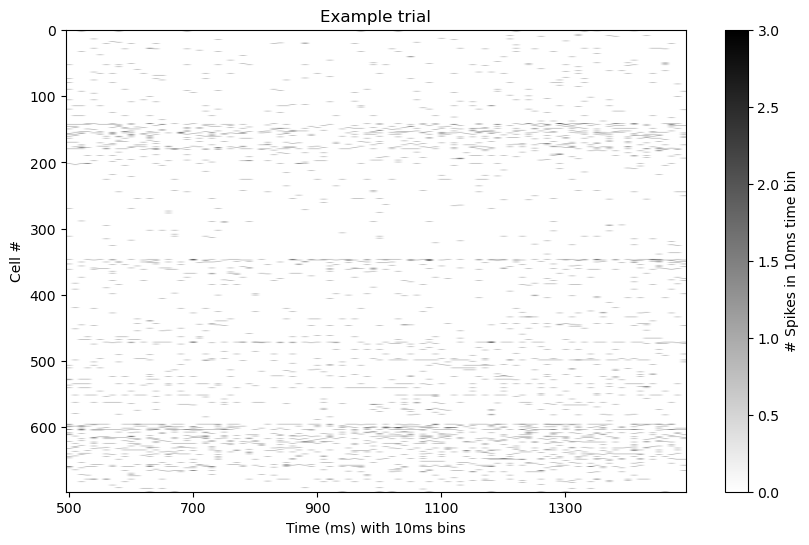

In [11]:
##### Visualise data from one trial to show time slicing
plt.figure(figsize = (10, 6))
plt.imshow(dat['spks'][dat['brain_area'] == 'MOs',0,:], cmap='gray_r', vmax = 3, vmin=0, aspect='auto')
plt.xlabel('Time (ms) with 10ms bins')
plt.ylabel('Cell #')
plt.colorbar(orientation='vertical', label='# Spikes in 0.01 s time bin')
plt.title('Example trial')
plt.show()

plt.figure(figsize = (10, 6))
plt.imshow(x[0,:,:].T, cmap='gray_r', vmax = 3, vmin=0, aspect='auto')
plt.xticks([0, 20, 40, 60, 80], [500, 700, 900, 1100, 1300]) 
plt.xlabel('Time (ms) with 10ms bins')
plt.ylabel('Cell #')
plt.colorbar(orientation='vertical', label='# Spikes in 10ms time bin')
plt.title('Example trial')
plt.show()

##### Dataloader

In [12]:
# batch_size of 34 used to match number of trials
batch_size = 34

# Create DataLoader for training data
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for validation data
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create DataLoader for test data
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##### Hyperparameters

In [13]:
# number of hidden RNN stages, inputs and outputs
hidden_size = x.shape[1]
input_size = x.shape[2]
output_size = y_train.shape[1]
num_layers = 1
learning_rate = 0.001
number_of_epochs = 1000
RNN_number_of_epochs = 70
LSTM_number_of_epochs = 100
GRU_number_of_epochs = 60

# early stopping not used
# RNN_patience = 5
# LSTM_patience = 5
# GRU_patience = 5

In [14]:
print(hidden_size)
print(input_size)
print(output_size)

100
698
3


##### Define RNN
Since the `hidden_size` is 250 we can expect to see either exploding or vanishing gradients in the RNN. For this case we can't expect the RNN to be able to predict well. But, as Dev did, we can reduce the `hidden_size` by slicing off data which doesn't correspond to wheel movement. 

In [15]:
# chatgpt 3.5 generated code
# RNN Model with Softmax
class RNNWithSoftmax(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNNWithSoftmax, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define the RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define the fully connected layer to map RNN output to class labels
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)

        # Use only the last time step's output for classification
        out = self.fc(out[:, -1, :]) 

        # Apply softmax activation
        return nn.functional.softmax(out, dim=1)  

##### Train the RNN: setup

In [16]:
# chatgpt 3.5 generated code
model = RNNWithSoftmax(input_size, hidden_size, output_size, num_layers).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

##### Train the RNN and plot training and validation losses and accuracies
Note that the trained model seems to remain resident on the graphics card unless we restart the notebook.

Epoch [1/70], Training Loss: 1.07036500, Training Accuracy: 0.4496
Epoch [1/70], Validation Loss: 1.07958597, Validation Accuracy: 0.2941
Epoch [2/70], Training Loss: 1.00776352, Training Accuracy: 0.5168
Epoch [2/70], Validation Loss: 1.06735802, Validation Accuracy: 0.3529
Epoch [3/70], Training Loss: 0.96925672, Training Accuracy: 0.7143
Epoch [3/70], Validation Loss: 1.04939395, Validation Accuracy: 0.4412
Epoch [4/70], Training Loss: 0.91269012, Training Accuracy: 0.7941
Epoch [4/70], Validation Loss: 1.03802580, Validation Accuracy: 0.4706
Epoch [5/70], Training Loss: 0.83418588, Training Accuracy: 0.8697
Epoch [5/70], Validation Loss: 0.99087742, Validation Accuracy: 0.5735
Epoch [6/70], Training Loss: 0.73246628, Training Accuracy: 0.9202
Epoch [6/70], Validation Loss: 0.81348380, Validation Accuracy: 0.7647
Epoch [7/70], Training Loss: 0.67037347, Training Accuracy: 0.9664
Epoch [7/70], Validation Loss: 0.91365957, Validation Accuracy: 0.7206
Epoch [8/70], Training Loss: 0.638

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Epoch [68/70], Training Loss: 0.55171489, Training Accuracy: 1.0000
Epoch [68/70], Validation Loss: 0.68512151, Validation Accuracy: 0.8676
Epoch [69/70], Training Loss: 0.55170849, Training Accuracy: 1.0000
Epoch [69/70], Validation Loss: 0.68479893, Validation Accuracy: 0.8676
Epoch [70/70], Training Loss: 0.55170219, Training Accuracy: 1.0000
Epoch [70/70], Validation Loss: 0.68459919, Validation Accuracy: 0.8676


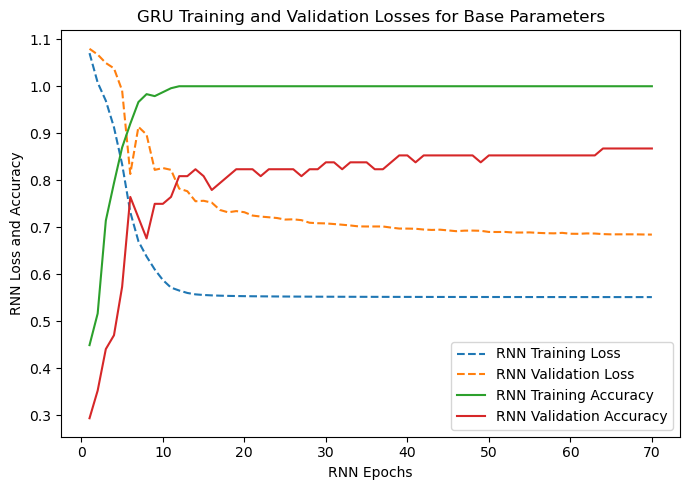

In [17]:
# chatgpt 3.5 generated code
# Training loop
# RNN_total_epochs = number_of_epochs
RNN_total_epochs = RNN_number_of_epochs

# Early stopping parameters
# best_val_loss = float('inf')
# epochs_since_best = 0

# Number of epochs to wait for improvement in validation loss
# patience = RNN_patience

# Lists to store training/validation losses and training/validation accuracies
RNN_train_losses = []  
RNN_val_losses = []    
RNN_train_accuracies = []  
RNN_val_accuracies = []    

for epoch in range(RNN_total_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, one_hot_labels in train_loader:
        inputs = inputs.to(device)
        one_hot_labels = one_hot_labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(one_hot_labels, dim=1))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update the total training loss for this epoch
        total_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == torch.argmax(one_hot_labels, dim=1)).sum().item()
        total_train += one_hot_labels.size(0)
    
    # Calculate average training loss and accuracy for this epoch
    average_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    
    # Store training loss and accuracy values
    RNN_train_losses.append(average_train_loss)
    RNN_train_accuracies.append(train_accuracy)
    
    # Print the training loss and accuracy for this epoch
    print(f'Epoch [{epoch+1}/{RNN_total_epochs}], Training Loss: {average_train_loss:.8f}, Training Accuracy: {train_accuracy:.4f}')
    
    # Validation loop
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, one_hot_labels in val_loader:
            inputs = inputs.to(device)
            one_hot_labels = one_hot_labels.to(device)
            
            # Forward pass (validation)
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(one_hot_labels, dim=1))
            
            # Update the total validation loss for this epoch
            total_val_loss += loss.item()
            
            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == torch.argmax(one_hot_labels, dim=1)).sum().item()
            total_val += one_hot_labels.size(0)
    
    # Calculate average validation loss and accuracy for this epoch
    average_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    
    # Check if validation loss has improved
    # if average_val_loss < best_val_loss:
    #    best_val_loss = average_val_loss
    #    epochs_since_best = 0
    # else:
    #    epochs_since_best += 1

    # Store validation loss and accuracy values
    RNN_val_losses.append(average_val_loss)
    RNN_val_accuracies.append(val_accuracy)
    
    # Print the validation loss and accuracy for this epoch
    print(f'Epoch [{epoch+1}/{RNN_total_epochs}], Validation Loss: {average_val_loss:.8f}, Validation Accuracy: {val_accuracy:.4f}')

    # Early stopping check
    # if epochs_since_best >= patience:
    #    print(f"Early stopping at epoch {epoch + 1}. Validation loss did not improve for {patience} epochs.")
    #    break

# Plot the losses and accuracies at the end of all epochs
RNN_x_epochs = list(range(1, RNN_total_epochs + 1))
plt.figure(figsize=(7, 5))

# Plot losses (dashed) and accuracies (solid)
plt.plot(RNN_x_epochs, RNN_train_losses, linestyle='--', label='RNN Training Loss')
plt.plot(RNN_x_epochs, RNN_val_losses, linestyle='--', label='RNN Validation Loss')
plt.plot(RNN_x_epochs, RNN_train_accuracies, label='RNN Training Accuracy')
plt.plot(RNN_x_epochs, RNN_val_accuracies, label='RNN Validation Accuracy')
plt.xlabel('RNN Epochs')
plt.ylabel('RNN Loss and Accuracy')
plt.title('GRU Training and Validation Losses for Base Parameters')
plt.legend()

plt.tight_layout()
plt.savefig('eps/RNN_11_base_spks_class.eps')
plt.savefig('svg/RNN_11_base_spks_class.svg')
plt.show()

##### Testing 

In [18]:
# chatgpt 3.5 generated code
# Test the model
model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for inputs, one_hot_labels in test_loader:
        inputs = inputs.to(device)
        one_hot_labels = one_hot_labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(one_hot_labels, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    print(f'Test Accuracy: {accuracy:.5f}')

Test Accuracy: 0.88235


##### Analysis RNN
Validation accuracy is 0.8676 at 70 epochs. Test accuracy is 0.88235.

##### Define LSTM

In [15]:
# chatgpt 3.5 generated code
# LSTM Model with Softmax
class LSTMWithSoftmax(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMWithSoftmax, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Use only the last time step's output for classification
        return nn.functional.softmax(out, dim=1)  # Apply softmax activation

##### Train LSTM: setup 

In [16]:
# chatgpt 3.5 generated code
model = LSTMWithSoftmax(input_size, hidden_size, output_size, num_layers).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### Train the LSTM and plot training and validation losses and accuracies
Note that the trained model seems to remain resident on the graphics card unless we restart the notebook.

Epoch [1/100], Training Loss: 1.07965849, Training Accuracy: 0.4370
Epoch [1/100], Validation Loss: 1.07977235, Validation Accuracy: 0.3088
Epoch [2/100], Training Loss: 1.04150816, Training Accuracy: 0.4328
Epoch [2/100], Validation Loss: 1.06279069, Validation Accuracy: 0.3088
Epoch [3/100], Training Loss: 1.00429222, Training Accuracy: 0.5084
Epoch [3/100], Validation Loss: 1.04411688, Validation Accuracy: 0.3529
Epoch [4/100], Training Loss: 0.93109364, Training Accuracy: 0.6765
Epoch [4/100], Validation Loss: 0.92092630, Validation Accuracy: 0.6471
Epoch [5/100], Training Loss: 0.95948417, Training Accuracy: 0.5084
Epoch [5/100], Validation Loss: 1.00464904, Validation Accuracy: 0.5000
Epoch [6/100], Training Loss: 0.89626897, Training Accuracy: 0.6681
Epoch [6/100], Validation Loss: 1.01435596, Validation Accuracy: 0.3824
Epoch [7/100], Training Loss: 0.84741327, Training Accuracy: 0.7941
Epoch [7/100], Validation Loss: 0.95411164, Validation Accuracy: 0.6912
Epoch [8/100], Train

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Epoch [91/100], Training Loss: 0.55157082, Training Accuracy: 1.0000
Epoch [91/100], Validation Loss: 0.65580037, Validation Accuracy: 0.8971
Epoch [92/100], Training Loss: 0.55156858, Training Accuracy: 1.0000
Epoch [92/100], Validation Loss: 0.65526125, Validation Accuracy: 0.8971
Epoch [93/100], Training Loss: 0.55156663, Training Accuracy: 1.0000
Epoch [93/100], Validation Loss: 0.65589961, Validation Accuracy: 0.8971
Epoch [94/100], Training Loss: 0.55156440, Training Accuracy: 1.0000
Epoch [94/100], Validation Loss: 0.65636563, Validation Accuracy: 0.8971
Epoch [95/100], Training Loss: 0.55156254, Training Accuracy: 1.0000
Epoch [95/100], Validation Loss: 0.65580544, Validation Accuracy: 0.8971
Epoch [96/100], Training Loss: 0.55156056, Training Accuracy: 1.0000
Epoch [96/100], Validation Loss: 0.65529659, Validation Accuracy: 0.8971
Epoch [97/100], Training Loss: 0.55155877, Training Accuracy: 1.0000
Epoch [97/100], Validation Loss: 0.65538034, Validation Accuracy: 0.8971
Epoch 

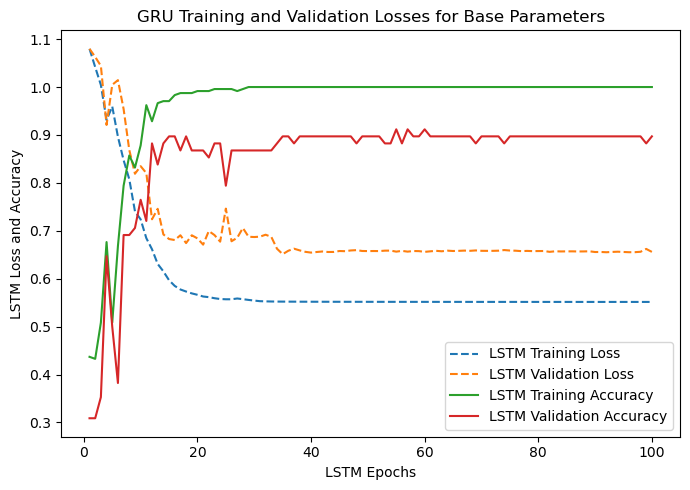

In [17]:
# chatgpt 3.5 generated code (this code is a copy of the RNN code)
# Training loop
# LSTM_total_epochs = number_of_epochs
LSTM_total_epochs = LSTM_number_of_epochs

# Lists to store training/validation losses and training/validation accuracies
LSTM_train_losses = []  
LSTM_val_losses = []    
LSTM_train_accuracies = []  
LSTM_val_accuracies = []    

for epoch in range(LSTM_total_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, one_hot_labels in train_loader:
        inputs = inputs.to(device)
        one_hot_labels = one_hot_labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(one_hot_labels, dim=1))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update the total training loss for this epoch
        total_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == torch.argmax(one_hot_labels, dim=1)).sum().item()
        total_train += one_hot_labels.size(0)
    
    # Calculate average training loss and accuracy for this epoch
    average_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    
    # Store training loss and accuracy values
    LSTM_train_losses.append(average_train_loss)
    LSTM_train_accuracies.append(train_accuracy)
    
    # Print the training loss and accuracy for this epoch
    print(f'Epoch [{epoch+1}/{LSTM_total_epochs}], Training Loss: {average_train_loss:.8f}, Training Accuracy: {train_accuracy:.4f}')
    
    # Validation loop
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, one_hot_labels in val_loader:
            inputs = inputs.to(device)
            one_hot_labels = one_hot_labels.to(device)
            
            # Forward pass (validation)
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(one_hot_labels, dim=1))
            
            # Update the total validation loss for this epoch
            total_val_loss += loss.item()
            
            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == torch.argmax(one_hot_labels, dim=1)).sum().item()
            total_val += one_hot_labels.size(0)
    
    # Calculate average validation loss and accuracy for this epoch
    average_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    
    # Store validation loss and accuracy values
    LSTM_val_losses.append(average_val_loss)
    LSTM_val_accuracies.append(val_accuracy)
    
    # Print the validation loss and accuracy for this epoch
    print(f'Epoch [{epoch+1}/{LSTM_total_epochs}], Validation Loss: {average_val_loss:.8f}, Validation Accuracy: {val_accuracy:.4f}')

# Plot the losses and accuracies at the end of all epochs
LSTM_x_epochs = list(range(1, LSTM_total_epochs + 1))
plt.figure(figsize=(7, 5))

# Plot losses (dashed) and accuracies (solid)
plt.plot(LSTM_x_epochs, LSTM_train_losses, linestyle='--', label='LSTM Training Loss')
plt.plot(LSTM_x_epochs, LSTM_val_losses, linestyle='--', label='LSTM Validation Loss')
plt.plot(LSTM_x_epochs, LSTM_train_accuracies, label='LSTM Training Accuracy')
plt.plot(LSTM_x_epochs, LSTM_val_accuracies, label='LSTM Validation Accuracy')
plt.xlabel('LSTM Epochs')
plt.ylabel('LSTM Loss and Accuracy')
plt.title('GRU Training and Validation Losses for Base Parameters')
plt.legend()

plt.tight_layout()
plt.savefig('eps/LSTM_11_base_spks_class.eps')
plt.savefig('svg/LSTM_11_base_spks_class.svg')
plt.show()

##### Testing 

In [18]:
# chatgpt 3.5 generated code
# Test the model
model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for inputs, one_hot_labels in test_loader:
        inputs = inputs.to(device)
        one_hot_labels = one_hot_labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(one_hot_labels, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    print(f'Test Accuracy: {accuracy:.5f}')

Test Accuracy: 0.88235


##### Analysis LSTM
Validation accuracy is 0.8971 at 100 epochs. Test accuracy is 0.88235.



##### Define GRU

In [15]:
# chatgpt 3.5 generated code
# GRU Model with Softmax
class GRUWithSoftmax(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRUWithSoftmax, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])  # Use only the last time step's output for classification
        return nn.functional.softmax(out, dim=1)  # Apply softmax activation

##### Train GRU: setup 

In [16]:
# chatgpt 3.5 generated code
model = GRUWithSoftmax(input_size, hidden_size, output_size, num_layers).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### Train the GRU and plot training and validation losses and accuracies
Note that the trained model seems to remain resident on the graphics card unless we restart the notebook.

Epoch [1/60], Training Loss: 1.06967264, Training Accuracy: 0.3950
Epoch [1/60], Validation Loss: 1.07179099, Validation Accuracy: 0.2941
Epoch [2/60], Training Loss: 1.02496640, Training Accuracy: 0.4370
Epoch [2/60], Validation Loss: 1.07337540, Validation Accuracy: 0.3088
Epoch [3/60], Training Loss: 0.98999724, Training Accuracy: 0.6218
Epoch [3/60], Validation Loss: 1.03721356, Validation Accuracy: 0.4412
Epoch [4/60], Training Loss: 0.95248083, Training Accuracy: 0.7647
Epoch [4/60], Validation Loss: 1.02865794, Validation Accuracy: 0.4853
Epoch [5/60], Training Loss: 0.89939122, Training Accuracy: 0.7773
Epoch [5/60], Validation Loss: 1.00547978, Validation Accuracy: 0.5294
Epoch [6/60], Training Loss: 0.81778904, Training Accuracy: 0.7899
Epoch [6/60], Validation Loss: 0.88179609, Validation Accuracy: 0.7206
Epoch [7/60], Training Loss: 0.74593396, Training Accuracy: 0.7899
Epoch [7/60], Validation Loss: 0.91848958, Validation Accuracy: 0.5735
Epoch [8/60], Training Loss: 0.716

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Epoch [59/60], Training Loss: 0.55165627, Training Accuracy: 1.0000
Epoch [59/60], Validation Loss: 0.67809755, Validation Accuracy: 0.8824
Epoch [60/60], Training Loss: 0.55165077, Training Accuracy: 1.0000
Epoch [60/60], Validation Loss: 0.67789629, Validation Accuracy: 0.8824


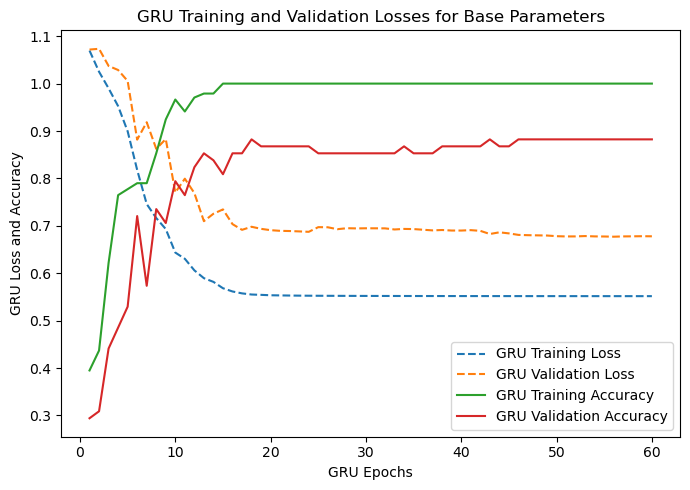

In [17]:
# chatgpt 3.5 generated code (this code is a copy of the RNN code)
# Training loop
# GRU_total_epochs = number_of_epochs
GRU_total_epochs = GRU_number_of_epochs

# Lists to store training/validation losses and training/validation accuracies
GRU_train_losses = []  
GRU_val_losses = []    
GRU_train_accuracies = []  
GRU_val_accuracies = []    

for epoch in range(GRU_total_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, one_hot_labels in train_loader:
        inputs = inputs.to(device)
        one_hot_labels = one_hot_labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(one_hot_labels, dim=1))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update the total training loss for this epoch
        total_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == torch.argmax(one_hot_labels, dim=1)).sum().item()
        total_train += one_hot_labels.size(0)
    
    # Calculate average training loss and accuracy for this epoch
    average_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    
    # Store training loss and accuracy values
    GRU_train_losses.append(average_train_loss)
    GRU_train_accuracies.append(train_accuracy)
    
    # Print the training loss and accuracy for this epoch
    print(f'Epoch [{epoch+1}/{GRU_total_epochs}], Training Loss: {average_train_loss:.8f}, Training Accuracy: {train_accuracy:.4f}')
    
    # Validation loop
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, one_hot_labels in val_loader:
            inputs = inputs.to(device)
            one_hot_labels = one_hot_labels.to(device)
            
            # Forward pass (validation)
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(one_hot_labels, dim=1))
            
            # Update the total validation loss for this epoch
            total_val_loss += loss.item()
            
            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == torch.argmax(one_hot_labels, dim=1)).sum().item()
            total_val += one_hot_labels.size(0)
    
    # Calculate average validation loss and accuracy for this epoch
    average_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    
    # Store validation loss and accuracy values
    GRU_val_losses.append(average_val_loss)
    GRU_val_accuracies.append(val_accuracy)
    
    # Print the validation loss and accuracy for this epoch
    print(f'Epoch [{epoch+1}/{GRU_total_epochs}], Validation Loss: {average_val_loss:.8f}, Validation Accuracy: {val_accuracy:.4f}')

# Plot the losses and accuracies at the end of all epochs
GRU_x_epochs = list(range(1, GRU_total_epochs + 1))
plt.figure(figsize=(7, 5))

# Plot losses (dashed) and accuracies (solid)
plt.plot(GRU_x_epochs, GRU_train_losses, linestyle='--', label='GRU Training Loss')
plt.plot(GRU_x_epochs, GRU_val_losses, linestyle='--', label='GRU Validation Loss')
plt.plot(GRU_x_epochs, GRU_train_accuracies, label='GRU Training Accuracy')
plt.plot(GRU_x_epochs, GRU_val_accuracies, label='GRU Validation Accuracy')
plt.xlabel('GRU Epochs')
plt.ylabel('GRU Loss and Accuracy')
plt.title('GRU Training and Validation Losses for Base Parameters')
plt.legend()

plt.tight_layout()
plt.savefig('eps/GRU_11_base_spks_class.eps')
plt.savefig('svg/GRU_11_base_spks_class.svg')
plt.show()

##### Testing

In [18]:
# chatgpt 3.5 generated code
# Test the model
model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for inputs, one_hot_labels in test_loader:
        inputs = inputs.to(device)
        one_hot_labels = one_hot_labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(one_hot_labels, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    print(f'Test Accuracy: {accuracy:.5f}')

Test Accuracy: 0.88235


##### Analysis GRU
Validation accuracy is 0.8824 at 60 epochs. Test accuracy is 0.88235.

##### Final notes
|  | epochs | validation accuracy (%) | test accuracy (%) | time (s) |
| --- | --- | ---| --- | --- |
| RNN | 70 | 86.76 | 88.235 | 1.6 |
| LSTM | 100 | 89.71 | 88.235 | 3.0 |
| GRU | 60 | 88.24 | 88.235 | 1.4 |

The RNN, LSTM and GRU performed equally well. The GRU was the fastest with similar time to the RNN if run to 70 epochs. What is not shown in the figures is how the different methods react when approaching their training limits. The RNN validation accuracy flattens out while the LSTM and GRU both jump to lower validation accuracy at higher epochs.

When the dataset was not shuffled all methods showed lower test accuracies, with the RNN being the worst at about 53%. This significant (35%) jump in performance for RNN dataset shuffling required an explanation. 

Generally we have an expectation of uniformity in the trials data of the dataset when we assume data leakage must be present to explain such a large variance in test accuracy. However, shuffling prior to slicing into training, validation and test sets cannot introduce data leakage because no results from training were carried over to the selection of data from the dataset. The test set was always held in reserve to be evaluated after training.

The uniformity hypothesis, however, is rarely true for neural data recordings. For the Steinmetz `spks` dataset, 340 trials were recorded in one session. We can expect to see reductions in probe sensitivity and mouse responses over time, and therefore trials, as the recording session progesses. When the trials are not shuffled the first 238 trials go towards the training set, the next 68 trials go into the validation set and the last 32 trials go into the test set. Therefore the test set is heavily biased towards reduced probe sensitivity effects and fatigued mouse behaviours.

By shuffling the dataset before slicing into training, validation and test sets we spread out the variance introduced by reduced probe sensitivity and mouse fatigue over the complete trial set, thereby increasing training ability and validation and test accuracies.

Dropout was tried, but there was a small reduction in accuracies. There was a warning that dropout should not be applied to a single layer (which is true for the RNN, LSTM, or GRU methods used in this notebook), so dropout was dropped.